**Custom Convolutional Neural Network**


'Tree CNN'

In [46]:
import os
import zipfile
import random
import torch
import time
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
files.upload()

In [48]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [49]:
!kaggle datasets download -d mcagriaksoy/trees-in-satellite-imagery

Dataset URL: https://www.kaggle.com/datasets/mcagriaksoy/trees-in-satellite-imagery
License(s): CC-BY-NC-SA-4.0
trees-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
# Unzip the dataset
with zipfile.ZipFile("trees-in-satellite-imagery.zip", "r") as zip_ref:
    zip_ref.extractall("trees_dataset")

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [51]:
dataset_path = "trees_dataset"

# List the contents
print("Dataset folders:", os.listdir(dataset_path))

Dataset folders: ['Trees in Satellite Imagery']


In [52]:
dataset_path = "trees_dataset/Trees in Satellite Imagery"

# List the first few files
print("Files in dataset:", os.listdir(dataset_path)[:10])


Files in dataset: ['Trees', 'NoTrees']


In [53]:
# Create ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load dataset
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",  # Binary classification (Tree vs No Tree)
    subset="training"
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# Print class labels
print("Class Indices:", train_data.class_indices)  # {'No Tree': 0, 'Tree': 1}

Found 8320 images belonging to 2 classes.
Found 2080 images belonging to 2 classes.
Class Indices: {'NoTrees': 0, 'Trees': 1}


In [54]:
# Define transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

# Define dataset path
dataset_path = "trees_dataset/Trees in Satellite Imagery"

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check class labels
print("Class Labels:", dataset.class_to_idx)
print(f"Dataset split: {train_size} training images, {val_size} validation images")

Class Labels: {'NoTrees': 0, 'Trees': 1}
Dataset split: 8320 training images, 2080 validation images


In [55]:

class TreeCNN(nn.Module):
    def __init__(self):
        super(TreeCNN, self).__init__()

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Extra Conv Layer
        self.bn4 = nn.BatchNorm2d(256)


        # Pooling & Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Prevent overfitting

        # Adaptive Pooling before FC layers (instead of manually flattening)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 output classes (Tree/NoTree)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))


        x = x.view(-1, 256 * 14 * 14)

        x = torch.flatten(x, 1)  # Flatten only batch dimension
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create model instance
model = TreeCNN()
print(model)


TreeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): Re

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Tree CNN Model Architecture Loaded!")


Tree CNN Model Architecture Loaded!


In [57]:
num_epochs = 20

train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    # Save best model based on validation loss

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        print(f"Best model saved at epoch {epoch+1} with Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")


Epoch [1/20], Train Loss: 1.1383, Val Loss: 0.4671, Val Accuracy: 79.18%
Best model saved at epoch 1 with Val Loss: 0.4671, Val Accuracy: 79.18%
Epoch [2/20], Train Loss: 0.3510, Val Loss: 0.3150, Val Accuracy: 88.65%
Best model saved at epoch 2 with Val Loss: 0.3150, Val Accuracy: 88.65%
Epoch [3/20], Train Loss: 0.3161, Val Loss: 0.8285, Val Accuracy: 71.78%
Epoch [4/20], Train Loss: 0.2807, Val Loss: 0.4348, Val Accuracy: 84.52%
Epoch [5/20], Train Loss: 0.2415, Val Loss: 0.2899, Val Accuracy: 88.12%
Best model saved at epoch 5 with Val Loss: 0.2899, Val Accuracy: 88.12%
Epoch [6/20], Train Loss: 0.2476, Val Loss: 0.1963, Val Accuracy: 93.61%
Best model saved at epoch 6 with Val Loss: 0.1963, Val Accuracy: 93.61%
Epoch [7/20], Train Loss: 0.2084, Val Loss: 0.1365, Val Accuracy: 95.58%
Best model saved at epoch 7 with Val Loss: 0.1365, Val Accuracy: 95.58%
Epoch [8/20], Train Loss: 0.2174, Val Loss: 0.1444, Val Accuracy: 95.05%
Epoch [9/20], Train Loss: 0.1833, Val Loss: 0.1852, Val 

In [58]:
# Load the best model weights
model.load_state_dict(torch.load("best_custom_cnn.pth", map_location=device))
model.eval()
print("Best Tree CNN Model Loaded for Evaluation!")


Best Tree CNN Model Loaded for Evaluation!


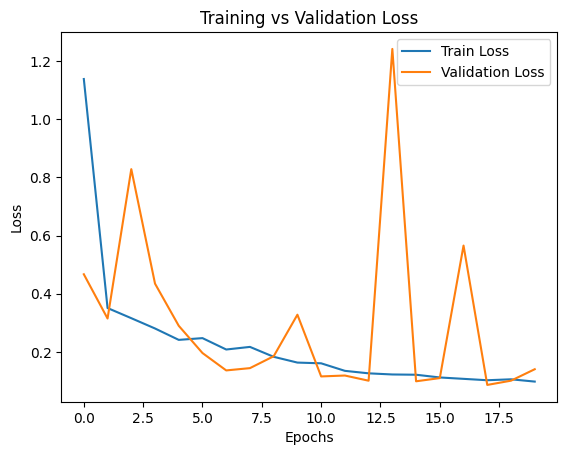

In [59]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


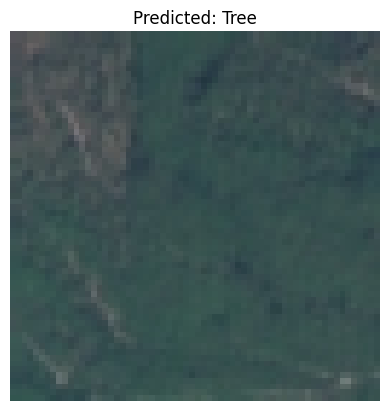

In [60]:

model.eval()

# Get a random test image
image_path = random.choice(dataset.samples)[0]

# Load image
image = Image.open(image_path)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image_tensor = transform_test(image).unsqueeze(0).to(device)

# Make prediction
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

# Show image and prediction
plt.imshow(image)
plt.title(f"Predicted: {'Tree' if predicted_class.item() == 1 else 'No Tree'}")
plt.axis("off")
plt.show()


In [61]:
y_true = []
y_pred = []

# Run predictions on validation data
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
print(f"Custom CNN Test Accuracy: {accuracy:.2f}%")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print Classification Report
class_report = classification_report(y_true, y_pred, target_names=["No Tree", "Tree"])
print("Classification Report:\n", class_report)


Custom CNN Test Accuracy: 96.97%
Classification Report:
               precision    recall  f1-score   support

     No Tree       0.97      0.97      0.97      1038
        Tree       0.97      0.97      0.97      1042

    accuracy                           0.97      2080
   macro avg       0.97      0.97      0.97      2080
weighted avg       0.97      0.97      0.97      2080



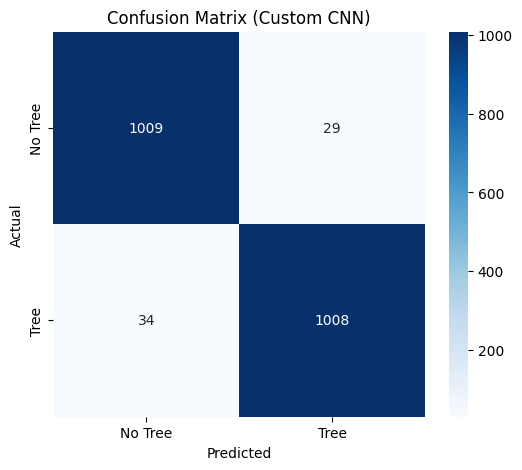

In [62]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tree", "Tree"], yticklabels=["No Tree", "Tree"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Custom CNN)")
plt.show()


In [ ]:

def get_model_size(model, model_name="custom_cnn"):
    """Saves model and calculates its size in MB."""
    torch.save(model.state_dict(), f"{model_name}.pth")  # Save model weights
    size = os.path.getsize(f"{model_name}.pth") / (1024 * 1024)  # Convert to MB
    os.remove(f"{model_name}.pth")  # Clean up
    print(f"{model_name} Size: {size:.2f} MB")
    return size

# Measure Custom CNN model size
get_model_size(model)


In [66]:

# Generate a random test image (batch size = 1, 3 color channels, 224x224 pixels)
test_image = torch.randn(1, 3, 224, 224).to(device)

def measure_inference_time(model, model_name="Custom CNN"):
    """Measures inference time on a single image."""
    model.eval()

    # Warm-up
    for _ in range(5):
        with torch.no_grad():
            _ = model(test_image)

    # Start measuring time
    start_time = time.time()
    with torch.no_grad():
        _ = model(test_image)
    end_time = time.time()

    inference_time = end_time - start_time
    print(f"{model_name} Inference Time: {inference_time:.6f} seconds per image")
    return inference_time

# Measure inference time
measure_inference_time(model)


Custom CNN Inference Time: 0.000886 seconds per image


0.0008859634399414062

In [69]:
import pandas as pd

# Define the model layers with type, output shape, and parameters count
model_layers_summary = [
    ("Conv2d", "32 x H x W", "3x3x3x32 + 32"),
    ("BatchNorm2d", "32 x H x W", "32"),
    ("Conv2d", "64 x H x W", "3x3x32x64 + 64"),
    ("BatchNorm2d", "64 x H x W", "64"),
    ("Conv2d", "128 x H x W", "3x3x64x128 + 128"),
    ("BatchNorm2d", "128 x H x W", "128"),
    ("Conv2d", "256 x H x W", "3x3x128x256 + 256"),
    ("BatchNorm2d", "256 x H x W", "256"),
    ("MaxPool2d", "256 x H/2 x W/2", "0"),
    ("Dropout", "256 x H/2 x W/2", "0"),
    ("AdaptiveAvgPool2d", "256 x 1 x 1", "0"),
    ("Linear", "512", "256x1x1x512 + 512"),
    ("Linear", "2", "512x2 + 2"),
    ("ReLU", "-", "0"),
]

# Create DataFrame
df_summary = pd.DataFrame(model_layers_summary, columns=["Layer (Type)", "Output Shape", "Params"])

# Display the table
print(df_summary)




         Layer (Type)     Output Shape             Params
0              Conv2d       32 x H x W      3x3x3x32 + 32
1         BatchNorm2d       32 x H x W                 32
2              Conv2d       64 x H x W     3x3x32x64 + 64
3         BatchNorm2d       64 x H x W                 64
4              Conv2d      128 x H x W   3x3x64x128 + 128
5         BatchNorm2d      128 x H x W                128
6              Conv2d      256 x H x W  3x3x128x256 + 256
7         BatchNorm2d      256 x H x W                256
8           MaxPool2d  256 x H/2 x W/2                  0
9             Dropout  256 x H/2 x W/2                  0
10  AdaptiveAvgPool2d      256 x 1 x 1                  0
11             Linear              512  256x1x1x512 + 512
12             Linear                2          512x2 + 2
13               ReLU                -                  0


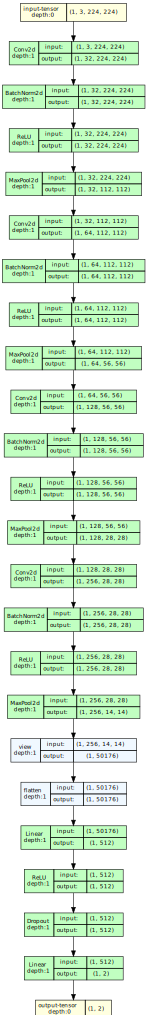

In [70]:
!pip install torchview  # Install first if not installed

from torchview import draw_graph

# Generate the visualization
model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device="cuda")

# Display
model_graph.visual_graph
